In [1]:
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from matplotlib_venn import venn3
from itertools import zip_longest
from typing import Set, List
import requests
import logging
import csv
from retry import retry
import os
import json
import time


In [2]:
REDDIT_API_URL = 'https://api.pushshift.io/reddit'
REDDIT_SEARCH_COMMENT_ENDPOINT = '/comment/search'
REDDIT_SEARCH_COMMENT_URL = f'{REDDIT_API_URL}{REDDIT_SEARCH_COMMENT_ENDPOINT}'
DESIRED_AUTHORS_AMOUNT = 1000
AUTHORS_CSV_FILE_NAME = 'subreddit_authors.csv'
SUBREDDITS_INTERSECTIONS_CSV_NAME = 'subreddits_intersections.csv'
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


In [3]:
subreddits_names = ['r/classicalmusic', "r/opera", "r/ambientmusic", "r/chillout", "r/deephouse", "r/DnB", "r/dubstep",
                    "r/EDM", "r/electronicdancemusic", "r/rock", "r/indieheads", "r/electronicmusic", "r/blues", "r/folk",
                    "r/Metal", "r/punk", "r/hiphopheads", "r/hiphop101", "r/rap", "r/Jazz", "r/reggae"]


In [4]:
def list_subreddit_authors(subreddit_name: str, limit: int = DESIRED_AUTHORS_AMOUNT) -> Set[str]:
    logger.info(
        f'Fetching <{limit}> subreddit_authors from <{subreddit_name}> subreddit')
    authors_set = set()
    params = {
        'subreddit': subreddit_name,
        'size': 1000,
        'fields': 'author'
    }
    index_base = 0
    index = 0
    while len(authors_set) < limit:
        logger.debug(
            f'Fetching the bulk that starts with the <{index_base+index}> author')
        index_base += index
        response = requests.get(REDDIT_SEARCH_COMMENT_URL, params=params)
        data = response.json()
        if not data['data']:
            break
        for index, comment in enumerate(data.get('data')):
            authors_set.add(comment.get('author'))
        params['before'] = data.get('data')[-1].get('created_utc')
        logger.debug('Still working...')
    logger.info(
        f'Done fetching <{limit}> subreddit_authors from <{subreddit_name}> subreddit')
    return authors_set


In [5]:
authors_by_subreddit: List[Set[str]] = []
for subreddit in subreddits_names:
    subreddit_authors = list_subreddit_authors(subreddit)
    authors_by_subreddit.append(subreddit_authors)


INFO:__main__:Fetching <1000> subreddit_authors from <r/classicalmusic> subreddit
INFO:__main__:Done fetching <1000> subreddit_authors from <r/classicalmusic> subreddit
INFO:__main__:Fetching <1000> subreddit_authors from <r/opera> subreddit
INFO:__main__:Done fetching <1000> subreddit_authors from <r/opera> subreddit
INFO:__main__:Fetching <1000> subreddit_authors from <r/ambientmusic> subreddit
INFO:__main__:Done fetching <1000> subreddit_authors from <r/ambientmusic> subreddit
INFO:__main__:Fetching <1000> subreddit_authors from <r/chillout> subreddit
INFO:__main__:Done fetching <1000> subreddit_authors from <r/chillout> subreddit
INFO:__main__:Fetching <1000> subreddit_authors from <r/deephouse> subreddit
INFO:__main__:Done fetching <1000> subreddit_authors from <r/deephouse> subreddit
INFO:__main__:Fetching <1000> subreddit_authors from <r/DnB> subreddit
INFO:__main__:Done fetching <1000> subreddit_authors from <r/DnB> subreddit
INFO:__main__:Fetching <1000> subreddit_authors from

In [6]:
def write_subreddits_authors_to_csv(values: Set[str], labels: List[str]) -> None:
    logger.info(
        f'Writing authors names of comments in <{len(values)}> subreddits to file: <{AUTHORS_CSV_FILE_NAME}>')
    with open(AUTHORS_CSV_FILE_NAME, mode='w') as file:
        writer = csv.writer(file)
        writer.writerow(labels)
        for row in zip_longest(*values, fillvalue=''):
            writer.writerow(row)
    logger.info('Done writing to CSV file')


In [7]:
def plot_and_save_venn_diagram(authors_by_subreddit: list, labels: List[str]):
    venn3(authors_by_subreddit[:3], set_labels=(labels))
    logger.info(
        'Plotting 1 exapmple venn diagram to demonstrated example intersection between subreddits')
    plt.savefig('venn_diagram.png')


In [8]:
def write_authors_intersections_to_csv(authors_by_subreddit: list, labels: List[str]):
    intersections = []
    intersections_labels = []

    logger.info('Calgulating intersections between subreddits...')
    for i in range(len(authors_by_subreddit)):
        for j in range(i+1, len(authors_by_subreddit)):
            intersections.append(
                authors_by_subreddit[i].intersection(authors_by_subreddit[j]))
            intersections_labels.append(f'{labels[i]} & {labels[j]}')
            logger.debug(
                f"{labels[i]} & {labels[j]} {authors_by_subreddit[i].intersection(authors_by_subreddit[j])}")

    with open(SUBREDDITS_INTERSECTIONS_CSV_NAME, mode='w') as file:
        writer = csv.writer(file)
        writer.writerow(intersections_labels)
        for row in zip_longest(*intersections, fillvalue=''):
            writer.writerow(row)
    logger.info(
        f'All intersections between subreddits were persisted as CSV file called <{SUBREDDITS_INTERSECTIONS_CSV_NAME}>')


write_authors_intersections_to_csv(authors_by_subreddit, subreddits_names)


INFO:__main__:Calgulating intersections between subreddits...
INFO:__main__:All intersections between subreddits were persisted as CSV file called <subreddits_intersections.csv>


INFO:__main__:Writing authors names of comments in <21> subreddits to file: <subreddit_authors.csv>
INFO:__main__:Done writing to CSV file
INFO:__main__:Plotting 1 exapmple venn diagram to demonstrated example intersection between subreddits


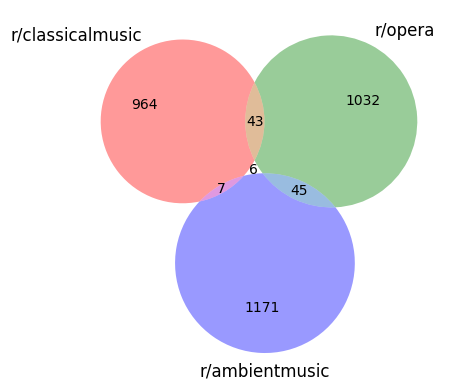

In [9]:
write_subreddits_authors_to_csv(authors_by_subreddit, subreddits_names)
plot_and_save_venn_diagram(authors_by_subreddit, subreddits_names)


# Diving Deeper

### Picking up 5 relatively distinct large musical genres communities and extract latest 1M comments and their authors


In [3]:
# Definitions
distinct_large_communities = [
    'r/indieheads', 'r/electronicmusic', 'r/hiphopheads', 'r/Metal', 'r/classicalmusic']
days_window = 1
comment_url = "https://api.pushshift.io/reddit/comment/search/"
submission_url = "https://api.pushshift.io/reddit/submission/search/"
blacklisted_users = ['[deleted]', 'AutoModerator']


In [4]:
@retry((requests.exceptions.RequestException, requests.exceptions.Timeout, requests.exceptions.HTTPError, requests.exceptions.ConnectionError, requests.exceptions.JSONDecodeError), delay=5, tries=5)
def throttle_get_request(url, params):
    try:
        response = requests.get(url, params=params)
        data = response.json().get("data", [])
        return data
    except Exception as e:
        logger.warning(
            f"handling bad response. response's status: {response.status_code}")
        raise e


In [7]:
def write_list_to_json_file(data_list, file_path):
    file_size = 0
    if os.path.isfile(file_path):
        file_size = os.stat(file_path).st_size

    with open(file_path, 'ab') as fp:
        if file_size > 0:
            fp.write(b',')
        for item in data_list:
            fp.write(json.dumps(item).encode('utf-8'))
            fp.write(b',')
        fp.seek(-1, os.SEEK_END)
        fp.truncate()
    fp.close()

def read_json_file(file_path):
    with open(file_path, 'r') as fp:
        data = fp.read()
        if data:
            # Remove trailing comma from the file
            if data[-1] == ',':
                data = data[:-1]
            # Load the JSON data into a dictionary
            data_dict = json.loads('[' + data + ']')
        else:
            data_dict = {}
    return data_dict


In [ ]:

def fetch_comments_from_subreddits_and_save_to_file(desired_comments_amount: int, subreddits: List[str]):
    desired_keys = ["id", "author", "permalink", "body", "created_utc"]
    for subreddit in subreddits:
        timestamp = int(time.time())
        output_file = f"data/{subreddit}.json"
        comments = read_json_file(output_file)
        comments_counter = 0
        if comments is not None and len(comments) > 0:
            timestamp = comments[-1]['created_utc']
            comments_counter += len(comments)
        params = {
            "subreddit": subreddit,
            "before": timestamp,
            "size": 1000,
            "sort": "created_utc",
        }
        while comments_counter < desired_comments_amount:
            data = throttle_get_request(comment_url, params)
            if len(data) == 0:
                break
            filtered_comments = [{key: comment.get(key)
                                  for key in desired_keys} for comment in data]
            comments_counter += len(filtered_comments)
            params["before"] = data[-1]['created_utc']
            write_list_to_json_file(
                filtered_comments, output_file)
        logger.info(f"Collected {comments_counter} comments from {subreddit}")


fetch_comments_from_subreddits_and_save_to_file(
    desired_comments_amount=1000000, subreddits=distinct_large_communities)


In [8]:
def get_authors_by_commuinity(directory):
    authors = {}
    for filename in os.listdir(directory):
        community_name = filename.split(".")[0]
        authors[community_name] = {}
        if filename.endswith(".json"):
            comments = read_json_file(directory + filename)
            logger.info(
                f'Iterating over {len(comments)} in {community_name} community')
            for comment in comments:
                comment_author = comment['author']
                if authors[community_name].get(comment_author):
                    authors[community_name][comment['author']] += 1
                else:
                    authors[community_name][comment['author']] = 1
            logger.info(
                f'Identified {len(authors[community_name])} authors in {community_name} community')
    return authors


authors = get_authors_by_commuinity('data/r/')


INFO:__main__:Iterating over 1000154 in Metal community
INFO:__main__:Identified 74055 authors in Metal community
INFO:__main__:Iterating over 980385 in classicalmusic community
INFO:__main__:Identified 93355 authors in classicalmusic community
INFO:__main__:Iterating over 1000834 in hiphopheads community
INFO:__main__:Identified 105576 authors in hiphopheads community
INFO:__main__:Iterating over 1219444 in indieheads community
INFO:__main__:Identified 117145 authors in indieheads community
INFO:__main__:Iterating over 1000813 in electronicmusic community
INFO:__main__:Identified 147127 authors in electronicmusic community


In [25]:
def get_authors_intersections(authors_dict):
    logger.info('Extracting the intersections of authors between communities')
    sets = {community_name: set(community_authors)
            for community_name, community_authors in authors_dict.items()}
    intersections = {}
    total_intersection = set()
    for k1 in sets:
        for k2 in sets:
            if k1 < k2:
                # Get the intersection of the sets corresponding to k1 and k2
                intersection = sets[k1].intersection(sets[k2])
                for blacklisted_user in blacklisted_users:
                    if intersection:
                        intersection.remove(blacklisted_user)

                # Add the intersection to the intersections dictionary
                key = k1 + '_' + k2
                intersections[key] = intersection
                total_intersection.update(intersection)


    for communities_pair in intersections:
        logger.info(
            f'The intersection of {communities_pair} is: [{len(intersections[communities_pair])} authors]; {intersections[communities_pair]}')
    return intersections, total_intersection


intersections_by_community, total_intersection = get_authors_intersections(authors)


INFO:__main__:Extracting the intersections of authors between communities
INFO:__main__:The intersection of Metal_classicalmusic is: [2643 authors]; {'Maloninho', 'LongLiveGrimes', 'Czapla_TV', 'Hi-There-Im-Using-R', 'BlackMetalistREEEEEE', 'Thatoneperson_111', 'Mumble_monster', 'TheNeatReader', 'Dettahatter', 'dadbot_3000', 'ironicfinn', 'Thoth7', 'jaiowners', '-Pelvis-', 'female_lenin', 'loulalot', 'power1211', 'szhins', 'Shoelacebasket', 'dfr0st', 'JuanPopa', '-Rhan-', 'SOSBTK', 'NulloK', 'budderer', 'TheCadaver', 'alfonso_x', 'ajleece', 'sci_fiBrofessor2566', 'Morbid__6angel', 'paperhammers', 'Ghost-in-the-Attic', 'grglmymayo', 'Johnisntbritish', 'vaguelyhuman', 'theDeviL4522912', 'xtracto', 'CaptainHowdey', 'KTerrestrial', 'Bortjort', 'ruskeeblue', 'FlabbyPigLegs', 'GDitChar1ie', 'iNvalidRequiem', 'llamakitana', 'volkKrovi', 'olibloody', 'eyesick', 'Ava33216', 'TheReverendsRequest', 'Pray4Snow2112', 'Leto33', 'sonofatruckload', 'vredditmirrorbot', 'award-cost-bot', 'ThrashingTrash

In [40]:
def recreate_authors_without_intersection(authors_dict):
    result = {community.split('/')[1]: {} for community in distinct_large_communities} 
    for community_name, community_authors in authors_dict.items():
        for author_name, comments_count in community_authors.items():
            if author_name not in total_intersection and author_name not in blacklisted_users:
                result[community_name][author_name] = comments_count
    return result

non_intersection_authors = recreate_authors_without_intersection(authors)

# Picking Up Active Users

Here we'll get the top commenters and plot the distribution of the amount of comments per author


In [44]:
for community_name, community_authors in non_intersection_authors.items():
    non_intersection_authors[community_name] = dict(sorted(community_authors.items(), key=lambda item: item[1], reverse=True))
logger.info('The authors in any community should now be sorted by the amount of comments per author')

INFO:__main__:The authors in any community should now be sorted by the amount of comments per author


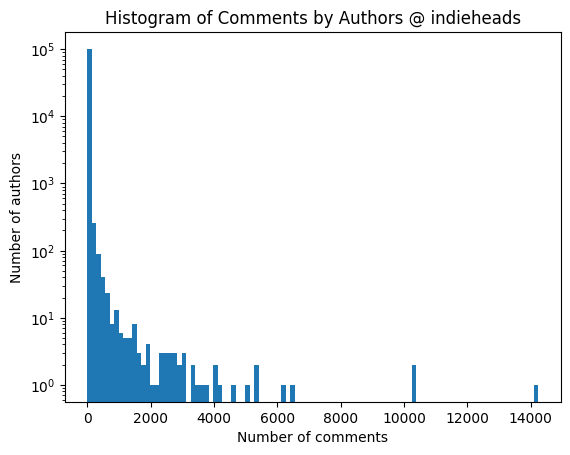

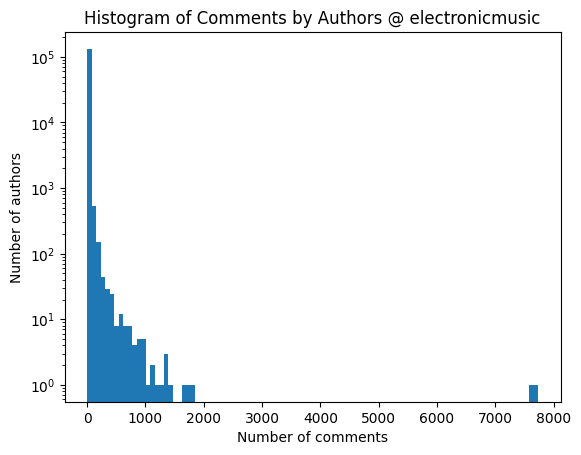

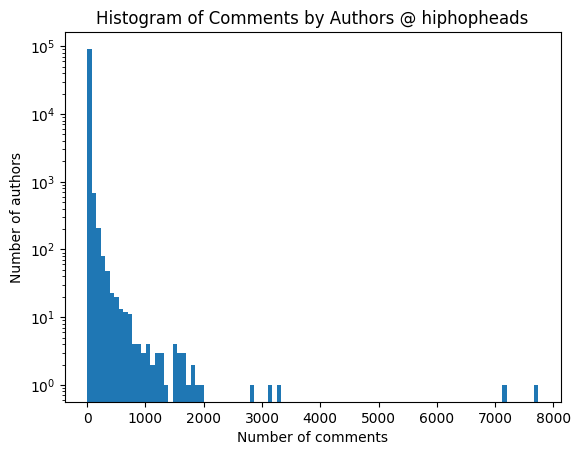

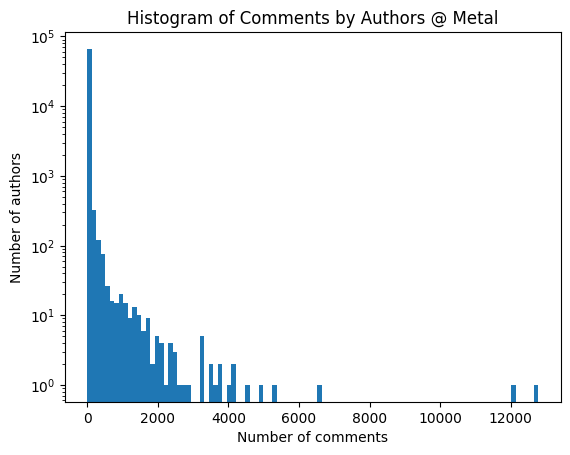

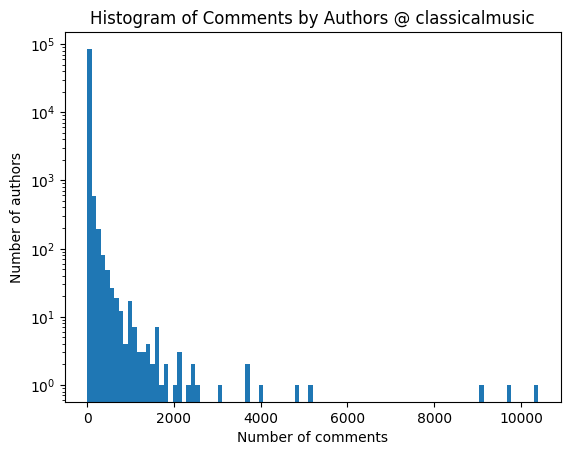

In [56]:
for community_name, community_authors in non_intersection_authors.items():
    values = list(community_authors.values())
    num_bins = 100
    plt.hist(values, bins=num_bins)
    plt.yscale('log')
    plt.xlabel('Number of comments')
    plt.ylabel('Number of authors')
    plt.title(f'Histogram of Comments by Authors @ {community_name}')
    plt.show()